In [12]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
from skimage.io import imread
from skimage import color, exposure
from skimage.transform import rescale
from skimage.util import view_as_blocks
from multiprocessing import Pool
from skimage.color import rgb2gray
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import multiprocess as mp
import pickle
from multiprocessingNotebook import runt
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


PICKLE_PATH = 'test_data.pickle'

NUM_TRAINING_IMAGES = 70000
NUM_TESTING_IMAGES = 50

NUM_SPACES_PER_BOARD = 2
PICTURE_DIMENSIONS = 400
block_width = PICTURE_DIMENSIONS // 8
block_height = PICTURE_DIMENSIONS // 8
num_channels = 3

In [6]:
# opens the chess boards.zip file into the chessBoards object
zipFilePath = '../chess boards.zip'
chessBoards = ZipFile(zipFilePath, 'r')

test = []
train = []
newpath = True

# extract the file names from the train and test folders in the zip archive
for file in chessBoards.namelist():
    # fills the file names from within the dataset subfolder
    """if file[:13] == 'dataset/test/':
        datasetTest.append(file)
    if file[:14] == 'dataset/train/':
        datasetTrain.append(file)"""

    if file[:4] == 'test':
        test.append(file)
    if file[:5] == 'train':
        train.append(file)

    # find any new file paths not accounted for
    """if file[:13] != 'dataset/test/' and \
        file[:14] != 'dataset/train/' and \
        file[:4] != 'test'and \
        file[:5] != 'train' and \
        newpath:
        print("new path: ", file)
        newpath = False"""

print("Files in test: ", len(test))
print("Files in train: ", len(train))

Files in test:  20000
Files in train:  80000


In [24]:
# Parallel Loads Board Images for Training Purposes
def HogTransform(img):
    first_image_gray = color.rgb2gray(img)

    fd, hog_image = hog(
        first_image_gray,
        orientations=8,
        pixels_per_cell=(8, 8),
        cells_per_block=(1, 1),
        visualize=True,
        block_norm='L2-Hys',
        feature_vector=True
    )

    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    hog_image_uint8 = (hog_image_rescaled * 255).astype(np.uint8)
    return hog_image_uint8

def read_and_store_modified_chess_images():
    return    

def fen_from_position(position, fen_string):
    rows = position // 8
    cols = position % 8
    
    character = fen_string[rows * 8 + cols]

    if character.isdigit():
        return ' ' * int(character)
    else:
        return character

def fen_from_filename(filename):
    parts = filename.split('/')
    fen_part = parts[-1].split('.')[0]

    fen_string = ''.join([' ' * int(char) if char.isdigit() else char for char in fen_part])
    fen_string = fen_string.replace('-', '')

    return fen_string

src = zipFilePath
random.shuffle(train)

print("Running...")
lock = mp.Lock()
manager = mp.Manager()
#data_dict = manager.dict({'fenstring': [], 'data': []})
data_dict = manager.list()
with mp.Pool(processes=10) as p:
    args = [(fileName, src, fen_from_filename, fen_from_position, NUM_SPACES_PER_BOARD, data_dict) for fileName in train[:NUM_TRAINING_IMAGES]]
    results = p.starmap(runt, args)

# Access the shared dictionary
print(len(data_dict))

combined_results = {'fenstring': [], 'data': []}

# Initialize lists to store all data and fenstring items
all_data_items = []
all_fenstring_items = []

for result in data_dict:
    # Extend all_data_items with result['data']
    all_data_items.extend(result['data'])
    
    # Extend all_fenstring_items with result['fenstring']
    all_fenstring_items.extend(result['fenstring'])

# Assign the combined lists to combined_results
combined_results['data'] = all_data_items
combined_results['fenstring'] = all_fenstring_items

joblib.dump(combined_results, PICKLE_PATH)
read_and_store_modified_chess_images()
    


Running...
910666


In [7]:
# Sequential loads Board Images for Training Purposes
def HogTransform(img):
    first_image_gray = color.rgb2gray(img)

    fd, hog_image = hog(
        first_image_gray,
        orientations=8,
        pixels_per_cell=(8, 8),
        cells_per_block=(1, 1),
        visualize=True,
        block_norm='L2-Hys',
        feature_vector=True
    )

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    hog_image_uint8 = (hog_image_rescaled * 255).astype(np.uint8)
    return hog_image_uint8

def fen_from_filename(filename):
    # Split the filename by '/'
    parts = filename.split('/')
    # Remove File Extension
    fen_part = parts[-1].split('.')[0]

    # Replace digits with spaces
    fen_string = ''.join([' ' * int(char) if char.isdigit() else char for char in fen_part])

    # Remove dashes
    fen_string = fen_string.replace('-', '')

    return fen_string

def read_and_store_modified_chess_images():
    def fen_from_position(position, fen_string):
        rows = position // 8
        cols = position % 8
        
        # Get the character at the corresponding position in the FEN string
        character = fen_string[rows * 8 + cols]

        # If the character is a number, return that many empty squares
        if character.isdigit():
            return ' ' * int(character)
        else:
            return character



    def loadImages(src, fileNames, destinationPickleFile, limit):
        data = {'fenstring': [], 'data': []}
        count = 0


        for file in fileNames:
            print("File:", file, "Count:", count)

            if count >= limit:
                break
            
            if file.endswith('.jpg') or file.endswith('.jpeg'):
                im = imread(os.path.join(src, file))
                fenString = fen_from_filename(file)

                patches = view_as_blocks(im, block_shape=(block_height, block_width, num_channels)).reshape(-1, block_height, block_width, num_channels)
                spaceTilesStored, boardPosition = 0, 0
                
                for patch in patches:
                    patchType = fen_from_position(boardPosition, fenString)
                    if patchType == ' ':
                        if spaceTilesStored > NUM_SPACES_PER_BOARD:
                            boardPosition += 1
                            continue
                        spaceTilesStored += 1
                    
                    hog_features = HogTransform(patch)
                    data['data'].append(hog_features)
                    data['fenstring'].append(patchType)
                    boardPosition += 1

            count += 1
        joblib.dump(data, destinationPickleFile)
        print(len(data))

    random.shuffle(train)  # Shuffle the file names list to pick a random file
    loadImages(zipFilePath, train, PICKLE_PATH, NUM_TRAINING_IMAGES)

read_and_store_modified_chess_images()

File: train/8-K4P2-5b2-2b5-8-8-4P1k1-8.jpeg Count: 0


KeyboardInterrupt: 

Num tiles stored: 910666
 


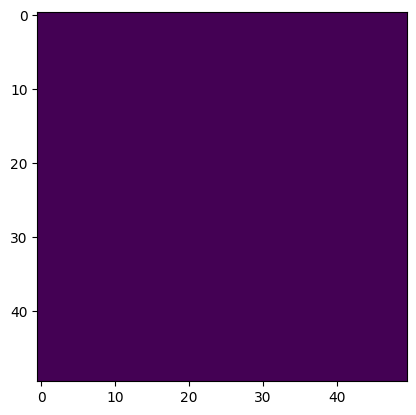

In [8]:
# Read Pickle File For Image Training
def load_pickle_file(file_path):
    try:
        data = joblib.load(file_path)
        return data
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except Exception as e:
        print(f"Error loading pickle file: {e}")
        return None

# Load the pickle file and output it to a variable
loaded_train_data = load_pickle_file(PICKLE_PATH)

print("Num tiles stored: " + str(len(loaded_train_data['data'])))

first_image = loaded_train_data['data'][3]
plt.imshow(first_image)

print(loaded_train_data['fenstring'][1])

File: test/1Q2n3-7p-8-8-1P2K3-6Pk-8-8.jpeg Count: 0
File: test/R1q5-1r2B1p1-B4r2-3K4-1r4n1-3b2p1-7k-8.jpeg Count: 1
File: test/8-7R-P1K3k1-8-4P2b-7r-8-3b1r2.jpeg Count: 2
File: test/rRn5-3nq3-7k-8-4n2n-B7-4N3-rR2K1BB.jpeg Count: 3
File: test/1KB1k3-7n-7P-8-8-2r5-8-6r1.jpeg Count: 4
File: test/n4k2-6P1-2p1Q3-K2B4-7q-1Rb1Q3-7N-4q1rq.jpeg Count: 5
File: test/B4R2-2K2Pb1-8-4b1k1-5rB1-8-2BP4-6N1.jpeg Count: 6
File: test/8-7N-K5p1-3N4-8-5n1k-8-8.jpeg Count: 7
File: test/4N3-3P3b-6Bn-8-8-2K5-3n2Pk-r5q1.jpeg Count: 8
File: test/1r6-1N2B3-b2r3N-P1r4k-4B3-n7-8-rK1b4.jpeg Count: 9
File: test/8-P6r-4P1k1-2bpP3-8-K2NB2b-4b3-8.jpeg Count: 10
File: test/1N4k1-Kn6-n7-1r5N-8-r3bbb1-1b6-2R2qr1.jpeg Count: 11
File: test/4Bn1k-2K1R3-3p2R1-3p1qp1-3R4-1n6-B6n-4r3.jpeg Count: 12
File: test/8-6Q1-2b5-8-4N3-1P4n1-5r1k-3K4.jpeg Count: 13
File: test/2b5-7N-8-3k2p1-2Q5-2K5-P7-5qb1.jpeg Count: 14
File: test/8-8-7r-6b1-1PP5-1K4k1-R7-1nbB3R.jpeg Count: 15
File: test/8-B6k-8-5K2-2BR4-5R2-5P2-B7.jpeg Count: 16
File: t

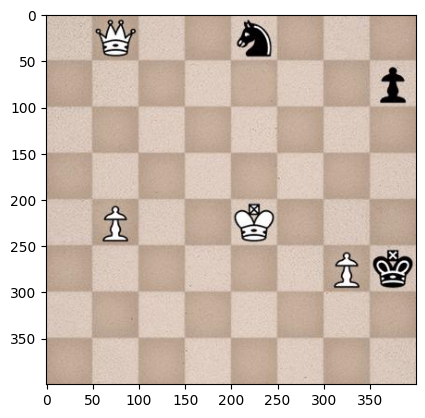

In [9]:
# Loads Board Images For Testing Purposes
def load_test_images(src, fileNames, limit):
    count = 0
    testImages = []
    for file in fileNames[:NUM_TESTING_IMAGES]:
        print("File:", file, "Count:", count)
        if count >= limit:
            break
        if file.endswith('.jpg') or file.endswith('.jpeg'):
            im = imread(os.path.join(src, file))
            fenString = file
            testImages.append((im, fenString))
            count += 1
    return testImages

random.shuffle(test)  # Shuffle the file names list to pick a random file
loaded_test_images = load_test_images(zipFilePath, test, NUM_TESTING_IMAGES)
first_image = loaded_test_images[0][0]
plt.imshow(first_image)
plt.show()

In [ ]:
def SVM_Predict_Individual_Pieces():
    
    X = np.array(loaded_train_data['data'])
    y = np.array(loaded_train_data['fenstring'])

    # Filter out data where fenstring is not ' '
    #X_filtered = [X[i] for i, fenstring in enumerate(loaded_train_data['fenstring']) if fenstring != ' ']
    #y_filtered = [fenstring for fenstring in loaded_train_data['fenstring'] if fenstring != ' ']

    # Flatten each HOG image in X_filtered
    X_flat_filtered = [img.flatten() for img in X]

    # Convert to numpy array
    X_flat_filtered = np.array(X_flat_filtered)

    # Encode FEN strings into numerical labels
    label_encoder = LabelEncoder()
    y_encoded_filtered = label_encoder.fit_transform(y)

    # Split the filtered data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_flat_filtered, y_encoded_filtered, test_size=0.2, random_state=42)

    # Train SVM classifier
    svm_classifier = SVC(kernel='linear')
    svm_classifier.fit(X_train, y_train)

    # Predict FEN string labels for the test set
    y_pred = svm_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("F1 Score:", f1)

    # Calculate confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=label_encoder.classes_)
    disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

SVM_Predict_Individual_Pieces()

In [10]:
def balance_data(X, y):
    # Find the class with the fewest samples
    class_counts = np.bincount(y)

    # Find the smallest class count (minority class)
    minority_class_count = min(class_counts)

    # Resample each class to have the same number of samples
    balanced_X = []
    balanced_y = []
    for class_label in np.unique(y):
        class_X = X[y == class_label]
        class_y = y[y == class_label]
        class_X_resampled, class_y_resampled = resample(class_X, class_y, replace=True, n_samples=minority_class_count, random_state=42)
        balanced_X.extend(class_X_resampled)
        balanced_y.extend(class_y_resampled)

    return np.array(balanced_X), np.array(balanced_y)

def SVM_Partition_Data():
    X = np.array(loaded_train_data['data'])
    y = np.array(loaded_train_data['fenstring'])

    # Display the number of occurrences for each fenstring value before balancing
    unique_labels, counts = np.unique(y, return_counts=True)
    for label, count in zip(unique_labels, counts):
        print(f"Fenstring '{label}': {count} occurrences")

    # Flatten each HOG image in X
    X_flat_filtered = [img.flatten() for img in X]

    # Convert to numpy array
    X_flat_filtered = np.array(X_flat_filtered)

    # Encode FEN strings into numerical labels
    label_encoder = LabelEncoder()
    y_encoded_filtered = label_encoder.fit_transform(y)

    # Balance the data
    X_balanced, y_balanced = balance_data(X_flat_filtered, y_encoded_filtered)
    #X_balanced = X_flat_filtered
    #y_balanced = y_encoded_filtered 

    # Display the number of occurrences for each fenstring value after balancing
    unique_labels, counts = np.unique(y_balanced, return_counts=True)
    for label, count in zip(unique_labels, counts):
        print(f"Fenstring '{label_encoder.inverse_transform([label])[0]}': {count} occurrences")

    # Split the balanced data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, label_encoder

X_train, X_test, y_train, y_test, label_encoder = SVM_Partition_Data()


Fenstring ' ': 210000 occurrences
Fenstring 'B': 61436 occurrences
Fenstring 'K': 70000 occurrences
Fenstring 'N': 62091 occurrences
Fenstring 'P': 63098 occurrences
Fenstring 'Q': 31109 occurrences
Fenstring 'R': 62096 occurrences
Fenstring 'b': 62261 occurrences
Fenstring 'k': 70000 occurrences
Fenstring 'n': 62168 occurrences
Fenstring 'p': 63081 occurrences
Fenstring 'q': 31176 occurrences
Fenstring 'r': 62150 occurrences
Fenstring ' ': 31109 occurrences
Fenstring 'B': 31109 occurrences
Fenstring 'K': 31109 occurrences
Fenstring 'N': 31109 occurrences
Fenstring 'P': 31109 occurrences
Fenstring 'Q': 31109 occurrences
Fenstring 'R': 31109 occurrences
Fenstring 'b': 31109 occurrences
Fenstring 'k': 31109 occurrences
Fenstring 'n': 31109 occurrences
Fenstring 'p': 31109 occurrences
Fenstring 'q': 31109 occurrences
Fenstring 'r': 31109 occurrences


In [1]:
# Fits the training model to the SVM model
def SVM_Fit_Model():

    # Train SVM classifier
    # Define the pipeline with the SVM classifier
    svm_classifier = Pipeline(steps=[ 
        ("svm", SVC(kernel='linear', max_iter=2000, random_state=42, probability=True, C = .1, coef0= 0, gamma = .1)) 
    ])

    svm_classifier.fit(X_train, y_train)

    joblib.dump(svm_classifier, 'svm_classifier.pkl')

SVM_Fit_Model()

NameError: name 'X_train' is not defined

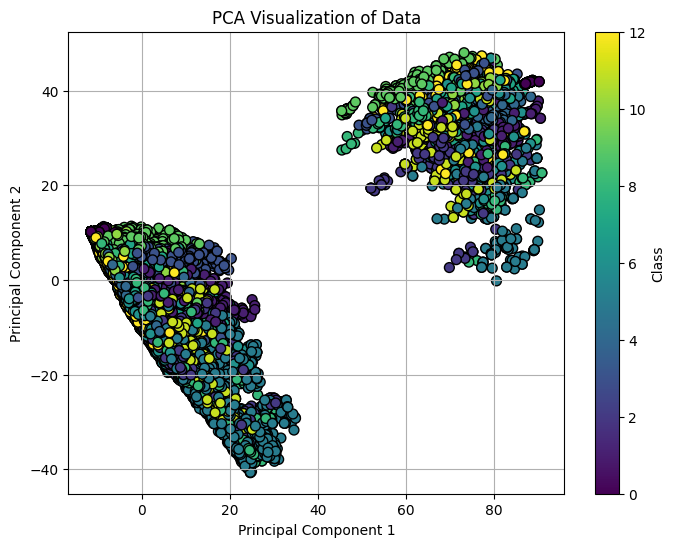

In [15]:
def visualize_PCA(X_train, y_train):
    # Standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)  # Reduce to 2 principal components for visualization
    X_train_pca = pca.fit_transform(X_train_scaled)

    # Plot the data points after PCA
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)
    plt.title('PCA Visualization of Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Class')
    plt.grid(True)
    plt.show()

visualize_PCA(X_train, y_train)

Predicted String: 6Q1-pp5N-3pB2p-p2p2P1-2p1K3-7B-3p4-p3kn1r
Actual String: 6Q1-1p5N-4B3-6P1-4K3-7B-8-4kn1r
The strings are different.
8
Predicted String: 7r-3Q1b2-7r-1n6-8-bR1pR1k1-5P2-3K4
Actual String: 7r-3Q1b2-7r-1n6-8-bR1pR1k1-5P2-3K4
The strings are the same.
8
Predicted String: 7r-4n2n-8-5Q2-P7-6R1-1B1R4-1n2KQk1
Actual String: 7r-4n2n-8-5Q2-P7-6R1-1B1R4-1n2KQk1
The strings are the same.
8
Predicted String: 1b6-q7-8-5p2-8-N1NKN3-1N6-6bk
Actual String: 1b6-q7-8-5p2-8-N1NKN3-1N6-6bk
The strings are the same.
8
Predicted String: 4N3-2p3P1-8-R1K5-R3k3-8-7p-1R6
Actual String: 4N3-6P1-8-R1K5-R3k3-8-7p-1R6
The strings are different.
9
Predicted String: 6r1-7q-3k4-1r4p1-8-3n2Q1-7b-K3q3
Actual String: 6r1-7q-3k4-1r4p1-8-3n2Q1-7b-K3q3
The strings are the same.
9
Predicted String: N1b5-1bp5-8-8-7k-8-4K3-6N1
Actual String: N1b5-1b6-8-8-7k-8-4K3-6N1
The strings are different.
10
Predicted String: 1Q2K3-2n5-2b5-2bR1k2-8-nn6-2b5-7n
Actual String: 1Q2K3-2n5-2b5-2bR1k2-8-nn6-2b5-7n
The strings are

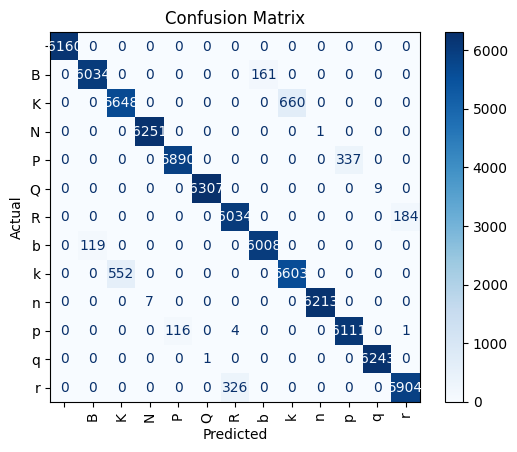

In [19]:
# Predicts the testing boards
def SVM_Classifier():
    def list_to_fen(input_list):
        fen_string = ""
        empty_count = 0
        line_count = 0
        
        for item in input_list:
            if line_count > 7:
                if empty_count > 0:
                    fen_string += str(empty_count)
                    empty_count = 0
                fen_string += str('-')
                line_count = 0

            line_count += 1
            if item == ' ':
                empty_count += 1
                
            else:
                if empty_count > 0:
                    fen_string += str(empty_count)
                    empty_count = 0
                fen_string += str(item)
        
        if empty_count > 0:
            fen_string += str(empty_count)
        
        # Removing ',', ']', and '[' from the fen_string
        fen_string = fen_string.replace("'", '').replace(']', '').replace('[', '')
        
        return fen_string

    def extract_fen_from_path(file_path):
        parts = file_path.split('/')
        parts2 = parts[1].split('.')
        return parts2[0]

    def SVM_Predict_Test_Board():
        correct = 0
        incorrect_chars = 0
        for image, _ in loaded_test_images:
            transformed_image = image
            patches = view_as_blocks(image, block_shape=(block_height, block_width, num_channels)).reshape(-1, block_height, block_width, num_channels)
            
            predicted_fenstring = []

            for patch in patches:

                hog_features = HogTransform(patch)
                
                #hog_features = patch
        
                flattened_features = hog_features.flatten()  # Flatten the features
                predicted_outcome = svm_classifier.predict([flattened_features[:2500]])
                predicted_class = label_encoder.inverse_transform(predicted_outcome) 

                predicted_fenstring.append(predicted_class)
            predicted_fenstring = list_to_fen(predicted_fenstring)
            actual_fenstring = extract_fen_from_path(_)
            print("Predicted String: " + predicted_fenstring)
            print("Actual String: " + actual_fenstring)
            if predicted_fenstring == actual_fenstring:
                print("The strings are the same.")
                correct += 1
            else:
                print("The strings are different.")
                # Count the number of different characters
                predicted_fenstring = fen_from_filename(predicted_fenstring)
                actual_fenstring = fen_from_filename(actual_fenstring)
                for pred_char, actual_char in zip(predicted_fenstring, actual_fenstring):
                    if pred_char != actual_char:
                        incorrect_chars += 1
            print(incorrect_chars)
            #plt.imshow(image)
            #plt.show()
        total_images = correct + incorrect_chars
        print(incorrect_chars / total_images)
        return

    svm_classifier = load_pickle_file('svm_classifier.pkl')

    # Predict FEN string labels for the test set
    y_pred = svm_classifier.predict(X_test)

    SVM_Predict_Test_Board()

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("F1 Score:", f1)

    # Calculate confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)

    # Get the unique class labels predicted by the classifier
    unique_labels = np.unique(np.concatenate((y_test, y_pred)))

    # Display confusion matrix with correct labels
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=label_encoder.inverse_transform(unique_labels))
    disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

SVM_Classifier()